[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m5cg1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m5cg1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\m5cg1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Number of words removed (appearing in ≥80% of summaries): 23
Silhouette Score: 0.297


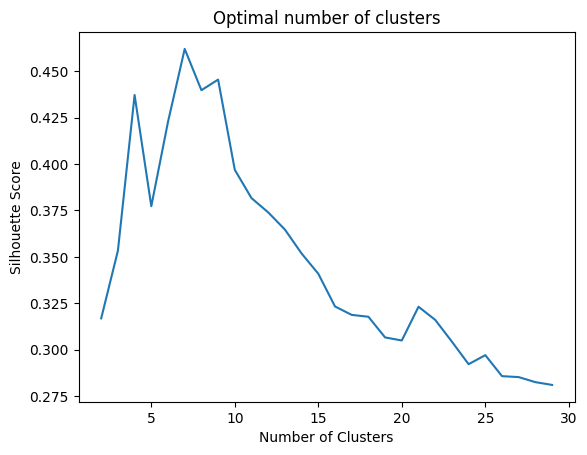

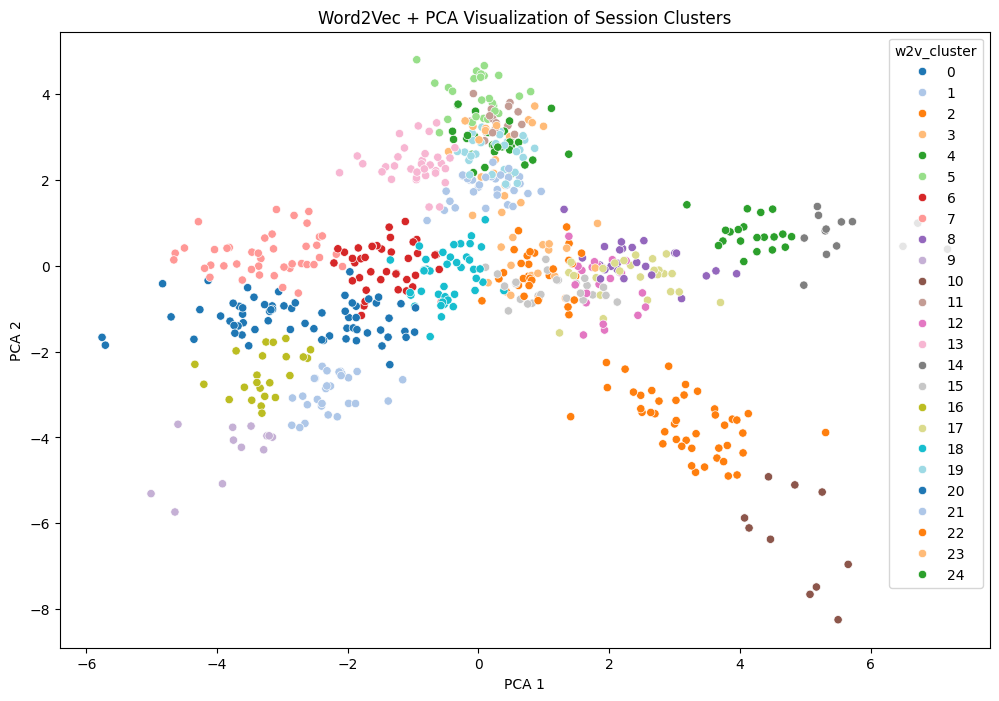


Cluster 0 (33 summaries):
[  7  10  30  43  62 102 134 251 302 316 321 334 342 379 390 398 405 419
 458 477 486 500 501 519 527 550 569 581 600 604 615 623 629]

Cluster 1 (32 summaries):
[ 16  27  28  88  90 111 116 119 132 133 149 178 200 206 293 345 350 371
 387 393 425 427 432 451 473 502 514 539 605 614 617 665]

Cluster 2 (44 summaries):
[ 34  37  46  57  84  91 115 154 165 168 172 187 191 242 254 278 288 299
 335 346 357 364 373 385 403 404 420 446 452 454 459 460 462 479 481 488
 510 554 591 595 610 620 621 660]

Cluster 3 (18 summaries):
[  5  19 110 121 131 145 257 269 284 406 416 439 464 564 594 597 601 631]

Cluster 4 (20 summaries):
[ 52  71 146 151 181 221 231 245 255 258 274 296 313 326 338 548 552 573
 596 598]

Cluster 5 (26 summaries):
[ 99 100 158 208 209 227 237 239 279 375 383 399 401 421 449 474 484 512
 547 557 575 592 611 616 640 662]

Cluster 6 (40 summaries):
[ 31  35  48  73  87  96 107 108 117 136 142 144 164 170 185 190 204 216
 233 249 275 309 312 325 327

C:\Users\m5cg1\AppData\Local\Temp\ipykernel_38592\924425081.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')


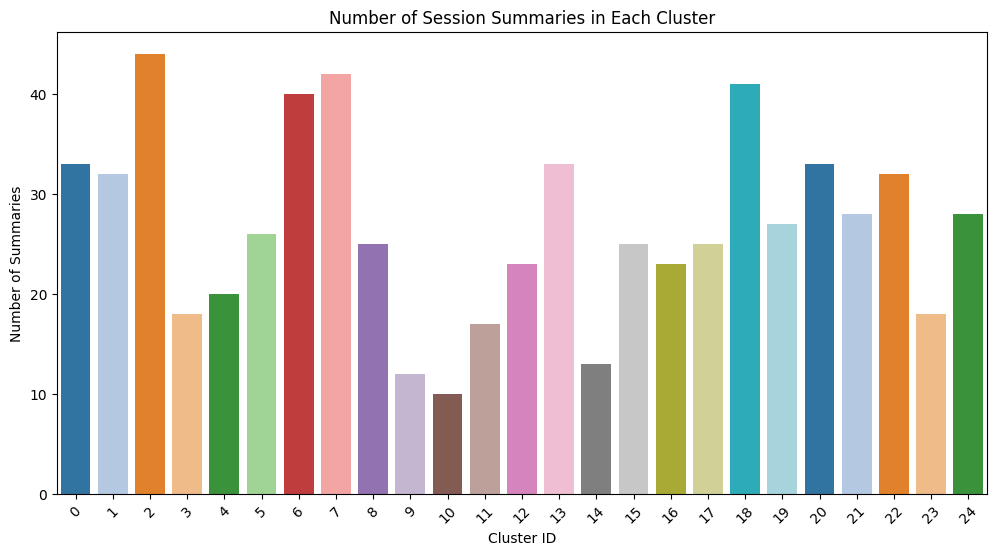


Summaries in Cluster 0 (Total: 33) — Sorted by Similarity:
Serial No: 251.0, Similarity: 0.9838
Serial No: 581.0, Similarity: 0.9817
Serial No: 486.0, Similarity: 0.9816
Serial No: 302.0, Similarity: 0.9816
Serial No: 405.0, Similarity: 0.9797
Serial No: 458.0, Similarity: 0.9795
Serial No: 10.0, Similarity: 0.9789
Serial No: 600.0, Similarity: 0.9783
Serial No: 30.0, Similarity: 0.9782
Serial No: 390.0, Similarity: 0.9776
Serial No: 342.0, Similarity: 0.9769
Serial No: 7.0, Similarity: 0.9758
Serial No: 550.0, Similarity: 0.9752
Serial No: 519.0, Similarity: 0.9740
Serial No: 379.0, Similarity: 0.9732
Serial No: 604.0, Similarity: 0.9719
Serial No: 500.0, Similarity: 0.9715
Serial No: 419.0, Similarity: 0.9676
Serial No: 43.0, Similarity: 0.9666
Serial No: 477.0, Similarity: 0.9665
Serial No: 398.0, Similarity: 0.9652
Serial No: 102.0, Similarity: 0.9652
Serial No: 527.0, Similarity: 0.9648
Serial No: 615.0, Similarity: 0.9647
Serial No: 334.0, Similarity: 0.9635
Serial No: 569.0, Si

In [4]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import silhouette_score
from collections import defaultdict
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ------------------------
# 1. Load Data
# ------------------------
df = pd.read_excel("D:/IITB/Studies/6th Sem/DS 203 Programming for Data Science/Project/Session-Summary-for-E6-project.xlsx")
df = df.dropna(subset=['Session_Summary'])

# ------------------------
# 2. Preprocessing
# ------------------------
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return tokens

df['tokens'] = df['Session_Summary'].apply(clean_text)

# ------------------------
# 3. Remove high-frequency words (appearing in >=80% of summaries)
# ------------------------
# Count in how many summaries each word appears
summary_counts = Counter()

for tokens in df['tokens']:
    unique_tokens = set(tokens)
    summary_counts.update(unique_tokens)

# Threshold: words appearing in >=80% of summaries
threshold = 0.3 * len(df)
common_words = set([word for word, count in summary_counts.items() if count >= threshold])

print(f"\nNumber of words removed (appearing in ≥80% of summaries): {len(common_words)}")

# Remove those words from tokens
df['filtered_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in common_words])

# ------------------------
# 4. Train Word2Vec Model (CBOW)
# ------------------------
w2v_model = Word2Vec(sentences=df['filtered_tokens'], vector_size=300, window=300, min_count=2, sg=0, workers=4, seed=42)

# ------------------------
# 5. Average Word Vectors for Each Summary
# ------------------------
def get_avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['vector'] = df['filtered_tokens'].apply(lambda x: get_avg_vector(x, w2v_model))
X_w2v = np.vstack(df['vector'].values)

# ------------------------
# 6. KMeans Clustering (25 sessions)
# ------------------------
kmeans = KMeans(n_clusters=25, random_state=42)
df['w2v_cluster'] = kmeans.fit_predict(X_w2v)

# Silhouette Score
sil_score = silhouette_score(X_w2v, df['w2v_cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# Silhouette scores for various K
scores = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_w2v)
    score = silhouette_score(X_w2v, labels)
    scores.append(score)

plt.plot(range(2, 30), scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal number of clusters")
plt.show()

# ------------------------
# 7. Visualize using PCA
# ------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_w2v)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['w2v_cluster'], palette='tab20', legend='full')
plt.title("Word2Vec + PCA Visualization of Session Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# ------------------------
# 8. Group Serial Numbers by Cluster
# ------------------------
cluster_groups = defaultdict(list)

for idx, row in df.iterrows():
    cluster_id = row['w2v_cluster']
    serial_no = row['SerialNo']
    cluster_groups[cluster_id].append(serial_no)

# Convert to list of arrays
session_clusters = [np.array(cluster_groups[i]) for i in range(25)]

# Display grouped arrays
for i, cluster in enumerate(session_clusters):
    print(f"\nCluster {i} ({len(cluster)} summaries):")
    print(cluster)

# ------------------------
# 9. Plot frequency of sessions in each cluster
# ------------------------
cluster_counts = df['w2v_cluster'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')
plt.title("Number of Session Summaries in Each Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Summaries")
plt.xticks(rotation=45)
plt.show()

# ------------------------
# 10. Compute Global Word2Vec Vector for Each Cluster
# ------------------------

# Dictionary to hold global vectors for each cluster
from scipy.spatial.distance import cosine

# Dictionary to store ordered summaries by similarity for each cluster
ordered_summaries_by_similarity = {}

for cluster_id in range(25):
    # Get global vector for the cluster
    global_vector = global_cluster_vectors[cluster_id]
    
    # Get all summaries in this cluster
    cluster_df = df[df['w2v_cluster'] == cluster_id][['SerialNo', 'vector']]
    
    # Compute cosine similarity between each summary's vector and the global vector
    cluster_df['similarity'] = cluster_df['vector'].apply(lambda vec: 1 - cosine(vec, global_vector) if np.linalg.norm(vec) != 0 and np.linalg.norm(global_vector) != 0 else 0)
    
    # Sort by decreasing similarity
    cluster_df = cluster_df.sort_values(by='similarity', ascending=False)
    
    # Store ordered SerialNos and similarity for this cluster
    ordered_summaries_by_similarity[cluster_id] = cluster_df[['SerialNo', 'similarity']].values.tolist()
    
    # Print all summaries for this cluster
    print(f"\nSummaries in Cluster {cluster_id} (Total: {len(cluster_df)}) — Sorted by Similarity:")
    for serial, sim in ordered_summaries_by_similarity[cluster_id]:
        print(f"Serial No: {serial}, Similarity: {sim:.4f}")


In [ ]:
from scipy.spatial.distance import cosine

# Cluster to work with
target_cluster_id = 0

# Get summaries in Cluster 0
cluster_df = df[df['w2v_cluster'] == target_cluster_id][['SerialNo', 'filtered_tokens', 'vector']]

for idx, row in cluster_df.iterrows():
    serial_no = row['SerialNo']
    tokens = row['filtered_tokens']
    summary_vector = row['vector']
    
    word_similarities = []
    
    # Use set(tokens) to avoid duplicate words
    for word in set(tokens):
        if word in w2v_model.wv:
            word_vector = w2v_model.wv[word]
            similarity = 1 - cosine(word_vector, summary_vector) if np.linalg.norm(word_vector) != 0 and np.linalg.norm(summary_vector) != 0 else 0
            word_similarities.append((word, similarity))
    
    # Sort words by decreasing similarity
    word_similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Print results for this summary
    print(f"\nSummary Serial No: {serial_no} — Top words by similarity to its own averaged vector:")
    for word, sim in word_similarities:
        print(f"{word}: {sim:.4f}")



Summary Serial No: 125 — Top words by similarity to its own averaged vector:
discrete: 0.9949
discrete: 0.9949
discrete: 0.9949
reference: 0.9937
categorization: 0.9925
fundamentally: 0.9899
continuous: 0.9859
continuous: 0.9859
continuous: 0.9859
learning: 0.9767
learning: 0.9767
arbitrary: 0.9702
unsupervised: 0.9678
temperature: 0.9667
nominal: 0.9619
nominal: 0.9619
ordinal: 0.9560
ordinal: 0.9560
label: 0.9557
label: 0.9557
label: 0.9557
level: 0.9540
level: 0.9540
level: 0.9540
ordering: 0.9513
ordering: 0.9513
ratio: 0.9499
measurement: 0.9477
measurement: 0.9477
forest: 0.9249
machine: 0.9118
quantity: 0.8983
x: 0.8917
x: 0.8917
assign: 0.8655
hierarchical: 0.7020
called: 0.6819
called: 0.6819
classification: 0.6668
clustering: 0.6408
clustering: 0.6408
interval: 0.6206
however: 0.5963
logistic: 0.5908
random: 0.5476
present: 0.5365
present: 0.5365
present: 0.5365
simple: 0.5251
number: 0.5043
technique: 0.4480
point: 0.3418
inherently: 0.3413
due: 0.2533
raw: 0.1283

Summary 

In [15]:
from collections import Counter
from scipy.spatial.distance import cosine

# Number of clusters
num_clusters = 25

# Initialize 2D list to hold top 20 keywords per cluster
cluster_keywords = []

# Loop through all clusters
for cluster_id in range(num_clusters):
    # Get summaries in this cluster
    cluster_df = df[df['w2v_cluster'] == cluster_id][['SerialNo', 'filtered_tokens', 'vector']]

    # List to collect all keywords in this cluster
    all_keywords = []

    # Process each summary in the cluster
    for idx, row in cluster_df.iterrows():
        tokens = row['filtered_tokens']
        summary_vector = row['vector']

        word_similarities = []

        # Use set(tokens) to avoid duplicate words within a summary
        for word in set(tokens):
            if word in w2v_model.wv:
                word_vector = w2v_model.wv[word]
                similarity = 1 - cosine(word_vector, summary_vector) if np.linalg.norm(word_vector) != 0 and np.linalg.norm(summary_vector) != 0 else 0
                word_similarities.append((word, similarity))

        # Sort words by decreasing similarity
        word_similarities.sort(key=lambda x: x[1], reverse=True)

        # Add words from this summary to the cluster's keyword list
        summary_keywords = [word for word, sim in word_similarities]
        all_keywords.extend(summary_keywords)

    # Count frequency of each word in this cluster
    keyword_counts = Counter(all_keywords)

    # Get top 20 most frequent keywords
    top_20_keywords = [word for word, count in keyword_counts.most_common(20)]

    # Append to the 2D list
    cluster_keywords.append(top_20_keywords)

# Print the 2D list
for cluster_id, keywords in enumerate(cluster_keywords):
    print(f"\nTop 20 keywords for Cluster {cluster_id}:")
    print(keywords)



Top 20 keywords for Cluster 0:
['confidence', 'interval', 'statistically', 'population', 'parameter', 'coefficient', 'independent', 'mlr', 'zero', 'started', 'significant', 'point', 'statistical', 'example', 'learned', 'term', 'le', 'variance', 'function', 'gradient']

Top 20 keywords for Cluster 1:
['point', 'outlier', 'average', 'problem', 'distribution', 'dataset', 'plot', 'better', 'distance', 'algorithm', 'started', 'imbalance', 'moving', 'transformation', 'missing', 'clustering', 'based', 'discussion', 'smote', 'minority']

Top 20 keywords for Cluster 2:
['learning', 'nominal', 'ratio', 'ordinal', 'interval', 'unsupervised', 'measurement', 'supervised', 'level', 'label', 'classification', 'x', 'clustering', 'discrete', 'continuous', 'temperature', 'ml', 'population', 'example', 'gender']

Top 20 keywords for Cluster 3:
['matrix', 'accuracy', 'recall', 'precision', 'function', 'confusion', 'logistic', 'metric', 'number', 'discussion', 'false', 'weight', 'positive', 'descent', 'de